# Water End Use Disaggregation 

### The goal:
Extract water use events from the raw trace and assign them to groups of classified water use events.

Outline:

+ Data
+ Filtering
+ Feature Extraction
+ Single VS Multiple Events
+ Breakdown Multiple Events into Simple Single Events
+ Clustering


First we import libraries, we will use:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels.api as sm  
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import datetime as dt
import time
from datetime import datetime, timedelta
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
sns.set()
from sklearn.preprocessing import StandardScaler
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D


If one of the packages is not installed, the following command will install the latest version of the package and its dependencies from the Python Packaging Index: pip install (packagename), Example:

In [ ]:
# If needed
pip install sklearn


## Data

We use water use data collected at 5 sec frequency from residential units located in Logan and Providence cities for demonstraion in this notebook.







In [2]:
# Parse the string representation as dates
dateparse = lambda x: pd.datetime.strptime(x, '%y-%m-%d %H:%M:%S')


In [3]:
# Read csv data file as a dataframe where the index column is the date/time column
data = pd.read_csv('/Users/nouri/Desktop/Nour/PhD/Disaggregated_Events/Jeff/019_0003.csv',index_col ='Time',parse_dates = ['Time'], date_parser=dateparse, skiprows = 3)
data = data.drop(columns=['Record'])

In [4]:
# Check the data
data.head()


,Pulses
Time,
2019-10-04 13:10:06,0
2019-10-04 13:10:10,0
2019-10-04 13:10:14,0
2019-10-04 13:10:18,0
2019-10-04 13:10:22,0


In [5]:
data.tail()


,Pulses
Time,
2019-10-09 10:01:46,0
2019-10-09 10:01:50,0
2019-10-09 10:01:54,0
2019-10-09 10:01:58,0
2019-10-09 10:02:02,0


Text(0, 0.5, 'Number of Pulses')

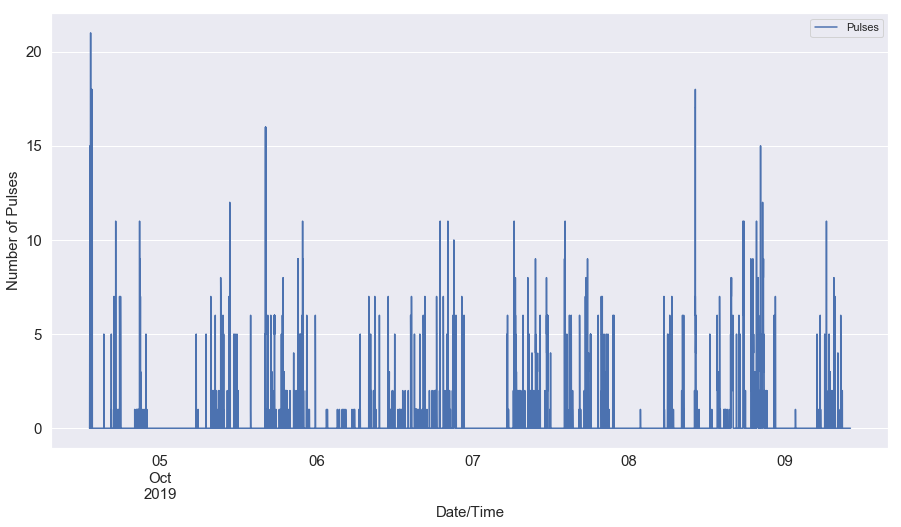

In [6]:
# Data Visualization
data.plot(figsize=(15,8),kind='line', fontsize = 15)
plt.xlabel('Date/Time', fontsize=15)
plt.ylabel('Number of Pulses', fontsize=15)


## Data Filtering

A low pass filter is applied here to generate a more harmonic series


In [7]:
# Copy the pulses attribute into a new array

signal = np.copy(data.Pulses.values)

In [8]:
# Remove noise (undesired extra pulses) in the trace 

def removal(signal, repeat):
    copy_signal = np.copy(signal)
    for j in range(repeat):
        for i in range(1, len(signal)):
            copy_signal[i - 1] = (copy_signal[i - 2] + copy_signal[i]) // 2
    return copy_signal

In [9]:
# Generate the new series 

def get(original_signal, removed_signal):
    buffer = []
    for i in range(len(removed_signal)):
        buffer.append(original_signal[i] - removed_signal[i])
    return np.array(buffer)

In [10]:
removed_signal = removal(signal, 1)
noise = get(signal, removed_signal)


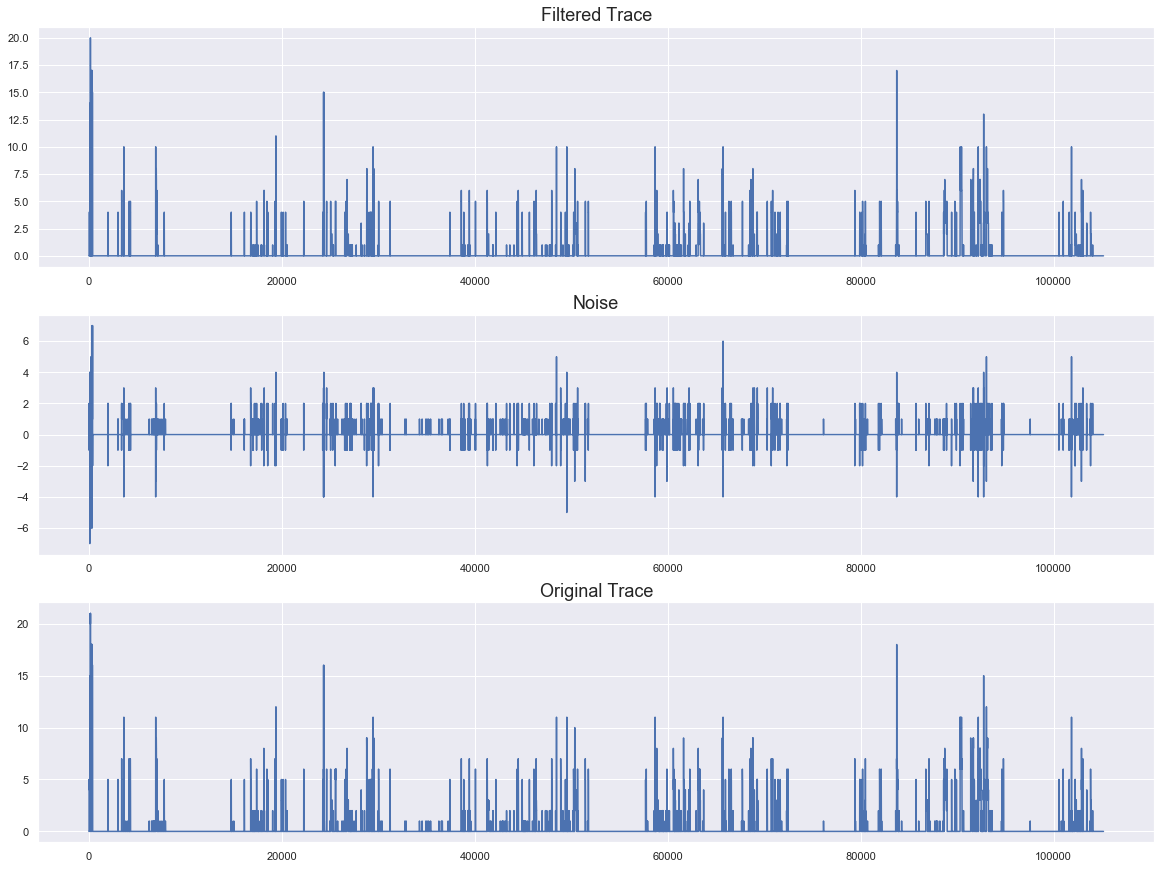

In [11]:
# Plot the filtered, original and noise traces

plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
plt.plot(removed_signal)
plt.title('Filtered Trace', fontsize = 18)
plt.subplot(3, 1, 2)
plt.plot(noise)
plt.title('Noise', fontsize = 18)
plt.subplot(3, 1, 3)
plt.plot(signal)
plt.title('Original Trace', fontsize = 18)
plt.show()


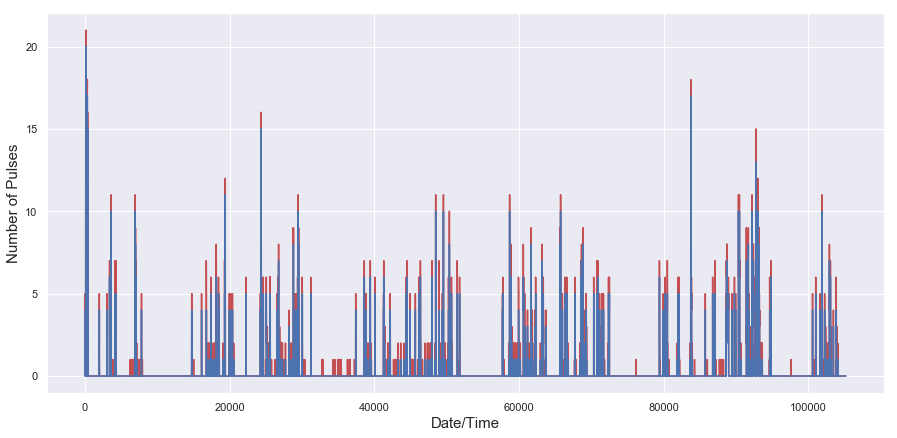

In [12]:
# Filterd and original data on the same plot

plt.figure(figsize=(15, 7))
plt.plot(signal, 'r')
plt.plot(removed_signal, 'b')
plt.xlabel('Date/Time', fontsize=15)
plt.ylabel('Number of Pulses', fontsize=15)
plt.show()

In [13]:
Time = np.copy(data.index)
Signal = np.copy(data.Pulses.values)
Removed_signal = removal(Signal, 1)
Noise = get(Signal, Removed_signal)

In [14]:
WaterData = pd.DataFrame({'Time':Time, 'FilteredData':Removed_signal, 'OriginalData':Signal })

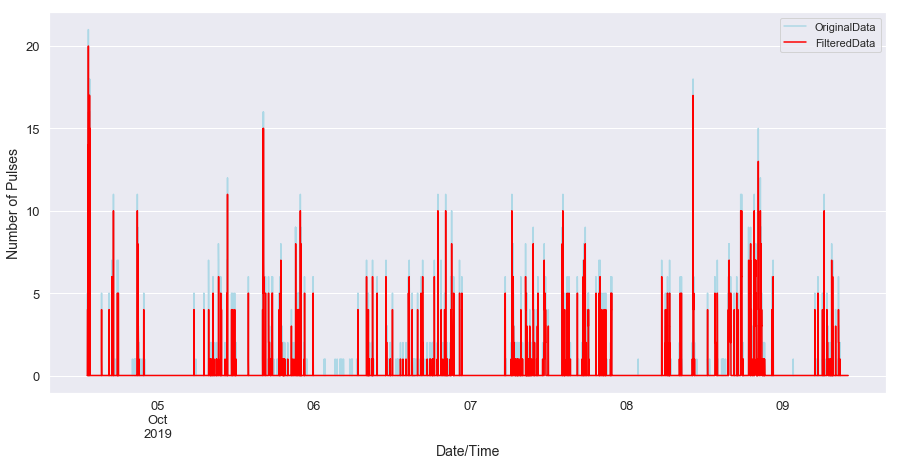

<Figure size 1080x504 with 0 Axes>

In [15]:
ax = plt.gca()
WaterData.plot(kind='line',x='Time',y='OriginalData', color='lightblue', ax=ax,figsize=(15, 7), fontsize = 13)
WaterData.plot(kind='line',x='Time',y='FilteredData',ax=ax, color='red',figsize=(15, 7))
plt.xlabel('Date/Time', fontsize=14)
plt.ylabel('Number of Pulses', fontsize=14)
plt.figure(figsize=(15, 7))
plt.show()

## Unclassified Events

Unclassified events are identified as the difference of pulses between the original and the filtered traces where the pulse value in the original trace is +1 pulse and the pulse value in the filtered trace is 0

In [16]:
# Create a blank dataframe to store features in it
UnclassifiedEvents = pd.DataFrame(columns = ['StartTime', 'EndTime', 'Volume'])

In [17]:
Events = 0
Unclassified = 0
j = 0
i = 0
for i in range(len(WaterData)) :    
    if (WaterData.loc[i , "OriginalData"] >= 1 and WaterData.loc[i, "FilteredData"] == 0 and (WaterData.loc[i + 1, "FilteredData"] == 0 and WaterData.loc[i - 1, "FilteredData"] == 0)):
        Unclassified = Unclassified + WaterData.loc[i, "OriginalData"]
        Events = Events + 1
        UnclassifiedEvents.loc[j,'StartTime'] = WaterData.loc[i, 'Time']
        UnclassifiedEvents.loc[j,'EndTime'] = WaterData.loc[i, 'Time']
        UnclassifiedEvents.loc[j,'Volume'] = WaterData.loc[i, 'OriginalData'] * 0.041619
        WaterData.loc[i, 'OriginalData'] = 0
        j = j + 1
        
Unclassified = Unclassified * 0.041619
print("Unclassified events volume is", Unclassified, "Gal")
print("Unclassified events number is", Events, "Events")


Unclassified events volume is 17.06379 Gal
Unclassified events number is 410 Events


In [18]:
# Export unclassifed Events as csv file
export_csv = UnclassifiedEvents.to_csv (r'/Users/nouri/Desktop/UnclassifedEvents.csv', index = None, header=True)

## Feature Extraction
Extract features of events that will be used to classify events later where an event begins when the flow rate through the meter changes from zero to any positive value, and finishes when the flow rate hits the zero again

In [19]:
# Create a blank dataframe to store events features in it
EventsDF = pd.DataFrame(columns = ['StartTime', 'EndTime', 'FilteredVolume','FilteredDuration','FilteredFlowRate', 'OriginalVolume', 'OriginalDuration', 'OriginalFlowRate', 'Number_of_peaks', 'Peak_Value' ,'Mode_Value', 'Event_Type'])

In [20]:
# Create a blank dataframe to store overlapping non aggregated events in it
OL_Events = pd.DataFrame(columns = ['Time', 'FilteredData', 'OriginalData' , 'Type'])

In [21]:
# Loop thru filtered data (data with removed leaks or noise)

In [22]:
pulse = 0 # number of pulses in the filtered trace
pulse2 = 0 # number of pulses in the original trace
i = 0 # Array index
j = 0 # Array index
duration = 0 # the duration of an event/s
k = 0 # Array index
st = '' # starting time
et = '' # end time
Dominant_Flow = 0
LList = [] # list of water use pulses of same event/s
V = 0 # number of different vertices of event/s
Peak = 0 # peak water use value of event/s
Dom_Test = [] # a list of flows used to evaluate the dominancy of the dominant flow
DT = 0 # Array index
counter3 = 0 # dominancy count of different flow rate values
OL = 0 # Binary variable, if 1: the event is overlapping, if 0 the event is single
Pulse = 0 # single pulse value in the filtered trace 
Pulse2 = 0 # single pulse value in the original trace 
Time = '' # time increments in the disaggregated set
I = 0 # Array index
J = 0 # Array index
S = 1
counter = 0

In [23]:
# Check data types if needed
print(type(duration))
print(type(pulse))
print(type(st))

<class 'int'>
<class 'int'>
<class 'str'>


In [24]:
# Loop thro water use data (filtered)
while (i < len(WaterData) - 1):
    if(WaterData.loc[i, "FilteredData"] == 0): 
        i = i + 1
        k = k + 1
        I = I + 1
    elif(WaterData.loc[i, "FilteredData"] != 0):
        k = i
        st = WaterData.loc[k - 1, "Time"] # initialize the starting time of an event ZZZZZZZ updated original bd filtered####
        while(WaterData.loc[i, "FilteredData"] != 0):
            pulse = pulse + WaterData.loc[i, "FilteredData"] # accumulate the number of pulses of and event from filtered data
            pulse2 = pulse2 + WaterData.loc[i, "OriginalData"] # accumulate the number of pulses of an event from original data
            duration = duration + 4 # calculate the duration of an event
            et = WaterData.loc[i , "Time"] # the end time of an event ############
            LList.append(WaterData.loc[i, "FilteredData"].tolist()) # List of pulse values of an event
            i = i + 1
        Dominant_Flow = mode(LList) # the dominant flow of an event
        Dominant_Flow = Dominant_Flow[0]
        Peak = max(LList) # the peak value of an event
        
        
        # Update durations and volumes of original data
        
        if (WaterData.loc[i, "FilteredData"] == 0 and WaterData.loc[i, "OriginalData"] != 0):
            et = WaterData.loc[i , "Time"]
            duration = duration + 4
            pulse2 = pulse2 + WaterData.loc[i, "OriginalData"]
            
        if (WaterData.loc[k - 1 , "FilteredData"] == 0 and WaterData.loc[k - 1, "OriginalData"] != 0):
            st = WaterData.loc[k - 2, "Time"]
            duration = duration + 4
            pulse2 = pulse2 + WaterData.loc[k - 1, "OriginalData"]
            
            
        if (WaterData.loc[i + 1, "FilteredData"] == 0 and WaterData.loc[i + 1, "OriginalData"] != 0):
            et = WaterData.loc[i + 1 , "Time"]
            duration = duration + 4
            pulse2 = pulse2 + WaterData.loc[i + 1, "OriginalData"]
            
        if (WaterData.loc[k - 2 , "FilteredData"] == 0 and WaterData.loc[k - 2, "OriginalData"] != 0):
            st = WaterData.loc[k - 3, "Time"]
            duration = duration + 4
            pulse2 = pulse2 + WaterData.loc[k - 2, "OriginalData"]
            

        
        if (WaterData.loc[k , "FilteredData"] != 0 and WaterData.loc[k , "OriginalData"] == 0):
            st = WaterData.loc[k , "Time"]
            duration = duration - 4
            
            
        if (WaterData.loc[i - 1 , "FilteredData"] != 0 and WaterData.loc[i - 1 , "OriginalData"] == 0):
            et = WaterData.loc[i - 2 , "Time"]
            duration = duration - 4
        
        
        
        for z in range(len(LList) - 2): # Number of different vertices in an event
            if(LList[z+1] == LList[z] and LList[z+1] != LList[z+2]):
                V = V + 1

        DF = np.array(LList)    # Dominant flow persistance  
        num_DF = (DF == Dominant_Flow[0]).sum
        NDF = num_DF
        
        while ((Peak - DT) > 0): # Multiple dominant flows test
            counter3 = LList.count(Peak - DT)
            Dom_Test.append(counter3)
            DT = DT + 1 
        
        Dom_Test.sort(reverse = True)
        
        for z in range(len(Dom_Test) - 1):  
            if((Dom_Test[0] - Dom_Test[1]) <= 3):  
                OL = 1 # overlapping events exist
            else:
                OL = 0 # overlapping events don't exist
            
        if ((LList.count(Peak) <=3) and Dom_Test[0] >=5):
            S = 1
        else:
            S= 0
        
        
        
        if (LList.count(Peak) <= 3): # updating the peak value if there is more than one dominant flow
            Peak = Peak - 1

        # Toilet or toilet + sink check
        ST = list (set (LList))
        ST.sort(reverse = True)
        
        for z in range(len(ST) - 1):  
            if(((ST[0] == 5 and ST[1] == 4) or (ST[0] == 6 and ST[1] == 5)) and Dom_Test[1] >= 4): # 3 and 4 were her as well
                OL = 1
            else:
                OL = 0
        

        if (duration ==0):
            duration = 4
            
        ###############################################
        # Uploading features in the EventsDF dataframe
        ###############################################
        
        EventsDF.loc[j,'StartTime'] = st # starting time of event
        EventsDF.loc[j,'EndTime'] = et # end time of event
        EventsDF.loc[j,'FilteredVolume'] = (pulse * 0.041619) # Volume in gals
        EventsDF.loc[j,'FilteredDuration'] = duration/60
        EventsDF.loc[j,'FilteredFlowRate'] =  ((pulse * 0.041619)/((duration/60)))  #0.041619
        EventsDF.loc[j,'OriginalVolume'] = pulse2 * 0.041619
        EventsDF.loc[j,'OriginalDuration'] = duration/60
        EventsDF.loc[j,'OriginalFlowRate'] =  ((pulse2 * 0.041619)/((duration/60)))
        EventsDF.loc[j,'Number_of_peaks'] = V
        EventsDF.loc[j,'Peak_Value'] = (Peak )#* 0.041619) # Value in gals
        EventsDF.loc[j,'Mode_Value'] = Dominant_Flow[0]
        if (Dominant_Flow[0] == Peak or V <= 2 or NDF == 3 or NDF == 2 or NDF == 1 or NDF == 0 or S == 1):
            EventsDF.loc[j, 'Event_Type'] = "Single"
        else:
            EventsDF.loc[j, 'Event_Type'] = "Multiple"
            
        if (OL == 1 and V >= 2 and S ==0):
            EventsDF.loc[j,'Event_Type'] = "Multiple"
            
            
        ###############################################
        # Events as increments
        ###############################################
        
        while(WaterData.loc[I, "FilteredData"] != 0 ):  #### Updated
            Pulse = WaterData.loc[I,"FilteredData"]
            Pulse2 = WaterData.loc[I, "OriginalData"]
            Time = WaterData.loc[I,"Time"]
            OL_Events.loc[J, 'Time'] = Time
            OL_Events.loc[J, 'FilteredData'] = Pulse
            OL_Events.loc[J, 'OriginalData'] = Pulse2
            if(Dominant_Flow[0] == Peak or V <= 2 or NDF == 3 or NDF == 2 or NDF == 1 or NDF == 0 or S ==1):
                OL_Events.loc[J,'Type'] = "Single"
            else:
                OL_Events.loc[J,'Type'] = "Multiple"
            if(OL == 1 and V >= 2 and S ==0):
                OL_Events.loc[J,'Type'] = "Multiple"
                
            I = I + 1
            J = J + 1
            
        ##############################################

        pulse = 0
        pulse2 = 0
        duration = 0
        Peak = 0
        j = j + 1
        st = '' 
        et = ''
        Dominant_Flow = 0
        LList.clear()
        V = 0
        num_DF = 0
        NDF = 0
        DT = 0
        counter3 = 0 # ADDED
        Dom_Test.clear()
        OL = 0
        ST = 0
        S = 1
        Pulse = 0
        Pulse2 = 0
        Time = ''
        J = J + 1

In [25]:
# Export the events (Single VS Multiple) as a csv file
export_csv = EventsDF.to_csv (r'/Users/nouri/Desktop/Events.csv', index = None, header=True)


In [26]:
EventsDF


,StartTime,EndTime,FilteredVolume,FilteredDuration,FilteredFlowRate,OriginalVolume,OriginalDuration,OriginalFlowRate,Number_of_peaks,Peak_Value,Mode_Value,Event_Type
0,2019-10-04 13:11:06,2019-10-04 13:15:06,9.61399,4,2.4035,10.8626,4,2.71564,2,4,4,Single
1,2019-10-04 13:15:58,2019-10-04 13:18:22,20.1436,2.4,8.39317,21.2257,2.4,8.84404,1,14,14,Single
2,2019-10-04 13:19:14,2019-10-04 13:21:42,24.7633,2.46667,10.0392,25.5124,2.46667,10.3429,6,20,16,Multiple
3,2019-10-04 13:22:26,2019-10-04 13:24:38,20.5598,2.2,9.34536,21.6835,2.2,9.85614,1,16,16,Single
4,2019-10-04 13:25:58,2019-10-04 13:28:30,24.9714,2.53333,9.85713,25.5541,2.53333,10.0871,2,17,17,Single
5,2019-10-04 13:29:18,2019-10-04 13:32:22,30.4235,3.06667,9.9207,30.7564,3.06667,10.0293,2,17,17,Single
6,2019-10-04 13:32:42,2019-10-04 13:35:22,23.7228,2.66667,8.89606,25.2627,2.66667,9.47352,1,15,15,Single
7,2019-10-04 15:21:30,2019-10-04 15:22:22,1.99771,0.933333,2.14041,2.28905,0.933333,2.45255,3,4,4,Single
8,2019-10-04 16:30:34,2019-10-04 16:31:30,1.95609,0.933333,2.09581,2.20581,0.933333,2.36336,1,4,4,Single
9,2019-10-04 16:55:46,2019-10-04 16:57:02,3.20466,1.26667,2.53,3.66247,1.26667,2.89143,2,5,4,Single


In [27]:
# Single Events
SingleEvents = EventsDF[EventsDF['Event_Type'] == "Single"].reset_index(drop=True)

# Multiple Events
MultipleEvents = EventsDF[EventsDF['Event_Type'] == "Multiple"].reset_index(drop=True)

In [28]:
# Multiple Events As Increments
MultipleEventsIncrements = OL_Events[OL_Events['Type'] == "Multiple"].reset_index(drop=True)

In [29]:
export_csv = MultipleEvents.to_csv (r'/Users/nouri/Desktop/MEA.csv', index = None, header=True)

In [30]:
export_csv = MultipleEventsIncrements.to_csv (r'/Users/nouri/Desktop/MED.csv', index = None, header=True)

In [32]:
export_csv = SingleEvents.to_csv (r'/Users/nouri/Desktop/SingleEvents.csv', index = None, header=True)

## Overlapping Events

Breakdown Multiple Events into Simple Single Events

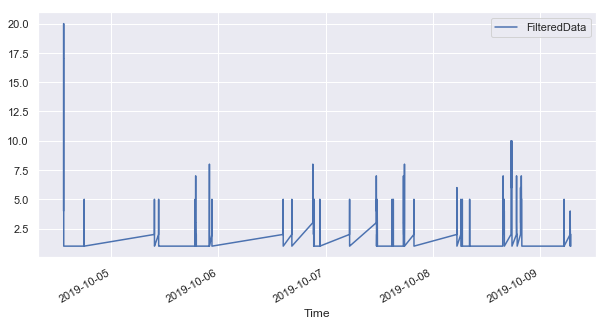

In [33]:
MultipleEventsIncrements.plot(x = 'Time', y = 'FilteredData', figsize=(10, 5))

In [34]:
Pulse = 0 # number of pulses of an event in filtered data
Pulse2 = 0 # number of pulses of an event in original data
i = 0 # Array index
j = 0 # Array index
st = '' # starting time of an event
et = '' # end time of an event
cutoff = 0 # cutoff value for overlapping events
counter = 0 #Array index
LList = [] # list of pulses of an event from filtered data
SG = 0 # a copy of list of pulses of an event from filtered data
peak = 0 # peak value of an event
LList2 = [] # list of pulses of an event from original data
SG2 = 0 # a copy of list of pulses of an event from original data
counter2 = 0 # Array index
SI = 0 # Index of first element greater than 0 in an array
V = 0 # number of vertices
num_DF = 0 # number of pulses of dominant flow
NDF = 0 # dominant flow presistance index
DT = 0 # Array index
counter3 = 0 #Array index
Dom_Test.clear() # a list of flows used to evaluate the dominancy of the dominant flow
OL = 0 # Binary variable, if 1: cutoff = 2nd dominant flow, if 0: cutoff = dominant flow
ST = 0 # Array of pulses sorted in decending order
STT = 0 # Array of pulses sorted in ascending order

In [35]:
# Initilize a dataframe and store seperated overlapping events features into it (simplified overlapping events)
SOLE = pd.DataFrame(columns = ['StartTime', 'EndTime', 'FilteredVolume','FilteredDuration', 'FilteredFlowRate', 'OriginalVolume', 'OriginalDuration', 'OriginalFlowRate','Number_of_peaks','Peak_Value'])

In [36]:
MEI = MultipleEventsIncrements.copy()

In [37]:
SOLE

,StartTime,EndTime,FilteredVolume,FilteredDuration,FilteredFlowRate,OriginalVolume,OriginalDuration,OriginalFlowRate,Number_of_peaks,Peak_Value


In [38]:
# Multiple events Disaggregation

while (i < (len(MEI) - 1)):
    while (((MEI.loc[i + 1, 'Time'] - MEI.loc[i, 'Time']).seconds == 4)):
        LList.append(MEI.loc[i, 'FilteredData'].tolist()) ##
        LList2.append(MEI.loc[i, 'OriginalData'].tolist()) ##ADDDED
        i = i + 1
        if (i + 1 == len(MEI)):
            break


    SG = LList.copy()
    SG2 = LList2.copy() 
    peak = max(LList)
    cutoff = mode(LList)
    CO = int(cutoff[0])
                
    #######################################################################
    # Disaggregation Part: one overlapping event = multiple single events
    #######################################################################
    
    # Inspect some features first to determine the cutoff value of the first event
    
    while(max(SG)>0):
   
        for z in range (len(SG) - 2): # number of different vertices
            if(SG[z+1] == SG[z] and SG[z+1] != SG[z+2] and SG[z+1] != 0 and SG[z+2] != 0 and SG[z] != 0):
                V = V + 1

        
        DF = np.array(SG) # Dominancy Test
        num_DF = (DF == max(SG)).sum
        NDF = num_DF
                                                    
        while((max(SG) - DT) > 0):
            counter3 = SG.count((max(SG)) - DT)
            Dom_Test.append(counter3)
            DT = DT + 1
            
        Dom_Test.sort(reverse = True)
        
        for z in range (len(Dom_Test) - 1):
            if((Dom_Test[0] - Dom_Test[1]) <= 3):
                OL = 1
            else:
                OL = 0
        
        # Sort values in an array to select the cutoff value
        ST = list(set(SG))
        ST.sort(reverse = True)
        
        STT = list(set(SG))
        STT.sort()
        

        res = []
        for val in STT:
            if val != 0 :
                res.append(val)
        res.sort(reverse = True)        
                        
        if ((OL == 1 and V >=2) or (((ST[0] == 5 and ST[1] == 4) or (ST[0] == 6 and ST[1] == 5)) and Dom_Test[0] >=4)):
            CO = int(res[1]) 
        
        
        SI = next(x for x, val in enumerate(SG)   #Get the Index of first element greater than 0 and set it as the starting time
                 if val > 0) 

            
        while (j <= (len(SG) - 1) and SG[j] > 0 ):
            counter = counter +1
            if(SG[j] >= CO):
                Pulse = Pulse + CO
                Pulse2 = Pulse2 + CO
                SG[j] = SG[j] - CO
                SG2[j] = SG2[j] - CO 
                
            elif(SG[j] < CO):
                Pulse = Pulse + SG[j]
                if (SG2[j] > 0):
                    Pulse2 = Pulse2 + SG2[j]
                SG[j] = SG[j] - SG[j]
                SG2[j] = SG2[j] - SG2[j]
            
            
            if (SG2[j] > 0 and SG[j] ==0):
                counter2 = counter2 + SG2[j]
                SG2[j] = 0
            
            j = j + 1
            if (j == len(SG)):
                break
            
        if (counter !=0):
            SOLE.loc[k,'FilteredVolume'] = Pulse * 0.041619
            SOLE.loc[k,'FilteredDuration'] = ((counter) *4)/60
            SOLE.loc[k,'FilteredFlowRate'] = (Pulse * 0.041619)/(((counter ) * 4)/60)
            SOLE.loc[k,'OriginalVolume'] = (Pulse2 + counter2) * 0.04169
            SOLE.loc[k,'OriginalDuration'] = ((counter) *4)/60
            SOLE.loc[k,'OriginalFlowRate'] = (Pulse2 * 0.041619)/(((counter ) * 4)/60)
            SOLE.loc[k,'Peak_Value'] =  CO
            SOLE.loc[k,'StartTime'] = MEI.loc[i - len(SG) + SI + 1, 'Time'] ######
            SOLE.loc[k,'EndTime'] = MEI.loc[i - len(SG) + j, 'Time']  ########
            SOLE.loc[k, 'Number_of_peaks'] = V

            k = k + 1
            j = 0
            
        
        
        # Cutoff check
        
        cutoff = int(mode(SG)[0])
        CO = cutoff
        

        
        if(counter == 0):
            j = j + 1
        else:
            j = 0
        

        counter = 0
        counter2 = 0
        Pulse = 0
        Pulse2 = 0
        t1 = 0
        t2 = 0
        
        if ((j > len(SG) - 1)):
            j = 0
        
        if (max(SG) == 0):
            break
        
        if (CO ==0):
            res = []
            for val in SG:
                if val != 0:
                    res.append(val)
            cutoff = int(mode(res)[0])
            CO = cutoff

        V = 0
        num_DF = 0
        NDF = 0
        counter3  = 0
        Dom_Test.clear()
        DT = 0
        OL = 0
        ST = 0
        STT = 0
        

        for z in range (len(SG) - 2):
            if(SG[z+1] == SG[z] and SG[z+1] != SG[z+2] and SG[z+1] != 0 and SG[z+2] != 0 and SG[z] != 0):
                V = V + 1
                
        DF = np.array(SG)
        num_DF = (DF == max(SG)).sum
        NDF = num_DF
        
        while((max(SG) - DT) > 0):
            counter3 = SG.count((max(SG)) - DT)
            Dom_Test.append(counter3)
            DT = DT + 1
            
        Dom_Test.sort(reverse = True)
        
        for z in range (len(Dom_Test) - 1):
            if ((Dom_Test[0] - Dom_Test[1]) <= 3):
                OL = 1
            else:
                OL = 0
                
        ST = list(set(SG))
        ST.sort(reverse = True)
        
        STT = list(set(SG))
        STT.sort()
        

        res = []
        for val in STT:
            if val != 0:
                res.append(val)
        res.sort(reverse = True)       
                
                
        if (CO == max(SG) or V < 2 or NDF == 2 or NDF == 1 or NDF == 0):
            CO = max(SG)
            
            
        if ((OL == 1 and V>=2) or (((ST[0] ==5 and ST[1] == 4) or (ST[0] ==6 and ST[1] == 5)) and Dom_Test[0] >=4)):
            CO = int(res[1])
            
   
            
        V = 0
        num_DF = 0
        NDF = 0
        DT = 0
        counter3 = 0
        Dom_Test.clear()
        OL = 0
        ST = 0
        STT = 0
        res = []
        
            

    
    
    i = i + 1
    LList.clear() 
    SG.clear()
    LList2.clear()
    SG2.clear()
    
    


In [39]:
SOLE = SOLE.reset_index(drop=True)

In [40]:
SOLE

,StartTime,EndTime,FilteredVolume,FilteredDuration,FilteredFlowRate,OriginalVolume,OriginalDuration,OriginalFlowRate,Number_of_peaks,Peak_Value
0,2019-10-04 13:19:18,2019-10-04 13:21:42,24.3471,2.46667,9.87045,25.014,2.46667,10.0729,6,19
1,2019-10-04 13:20:10,2019-10-04 13:20:42,0.374571,0.6,0.624285,0.50028,0.6,0.624285,0,1
2,2019-10-04 17:55:58,2019-10-04 17:57:10,2.91333,1.26667,2.3,3.08506,1.26667,2.3,2,4
3,2019-10-04 17:56:06,2019-10-04 17:56:46,0.457809,0.733333,0.624285,0.54197,0.733333,0.624285,0,1
4,2019-10-05 09:39:34,2019-10-05 09:40:38,2.37228,1.13333,2.09319,2.54309,1.13333,2.16664,4,4
5,2019-10-05 09:39:58,2019-10-05 09:40:14,0.208095,0.333333,0.624285,0.29183,0.333333,0.624285,0,1
6,2019-10-05 10:36:02,2019-10-05 10:37:50,3.2879,1.86667,1.76138,3.79379,1.86667,1.91745,2,4
7,2019-10-05 10:36:10,2019-10-05 10:36:42,0.374571,0.6,0.624285,0.62535,0.6,0.624285,0,1
8,2019-10-05 18:46:50,2019-10-05 18:48:02,2.91333,1.26667,2.3,3.21013,1.26667,2.3,3,4
9,2019-10-05 18:47:10,2019-10-05 18:47:38,0.332952,0.533333,0.624285,0.4169,0.533333,0.624285,0,1


In [41]:
export_csv = SOLE.to_csv (r'/Users/nouri/Desktop/OverlappingEvents.csv', index = None, header=True)

### Volume match check
 Calculate water use volume of the original dataset and compare it to water use volume after the disaggregation proceess:
 
 Raw data water use volume = single events water use volume + single events water use volume + single events water use volume

In [42]:
Original_Volume = WaterData['OriginalData'].sum() * 0.041619


In [43]:
print("Water use volume from the original dataset is", Original_Volume, "Gal")


Water use volume from the original dataset is 1190.5114950000002 Gal


In [44]:
SingleEvents_Volume = SingleEvents['OriginalVolume'].sum() 
MultipleEvents_Volume = SOLE['OriginalVolume'].sum() 
UnclassifiedEvents_Volume = UnclassifiedEvents['Volume'].sum() 
Total_Volume = SingleEvents_Volume + MultipleEvents_Volume



In [45]:
print("Water use volume from the disaggregated dataset is", Total_Volume, "Gal")



Water use volume from the disaggregated dataset is 1189.985292 Gal


In [46]:
print("Water use volume difference is", abs(Total_Volume - Original_Volume) , "Gal")



Water use volume difference is 0.5262030000001232 Gal


## CLUSTERING
Unsupervised K-Means clustering analysis will be used to create groups of events of similar features

In [47]:
dateparse = lambda x: pd.datetime.strptime(x, '%y-%m-%d %H:%M:%S') # parse the date/time attribute



In the previous steps 3 datasets of features were extracted 
+ Unclassified Events
+ Single Events
+ Overlapping Events

Here, we will merge the Single and Overlapping events into one dataset.

**Hint:** there is no need to account for unclassified events dataset since events there are already not prescribed to any end use

In [48]:
SingleEvents_Copy = SingleEvents.drop(columns=['Mode_Value', 'Event_Type'])
SOLE_Copy = SOLE.copy()

In [49]:
Events = pd.concat([SingleEvents_Copy, SOLE_Copy], ignore_index = True)

In [50]:
Events

,StartTime,EndTime,FilteredVolume,FilteredDuration,FilteredFlowRate,OriginalVolume,OriginalDuration,OriginalFlowRate,Number_of_peaks,Peak_Value
0,2019-10-04 13:11:06,2019-10-04 13:15:06,9.61399,4,2.4035,10.8626,4,2.71564,2,4
1,2019-10-04 13:15:58,2019-10-04 13:18:22,20.1436,2.4,8.39317,21.2257,2.4,8.84404,1,14
2,2019-10-04 13:22:26,2019-10-04 13:24:38,20.5598,2.2,9.34536,21.6835,2.2,9.85614,1,16
3,2019-10-04 13:25:58,2019-10-04 13:28:30,24.9714,2.53333,9.85713,25.5541,2.53333,10.0871,2,17
4,2019-10-04 13:29:18,2019-10-04 13:32:22,30.4235,3.06667,9.9207,30.7564,3.06667,10.0293,2,17
5,2019-10-04 13:32:42,2019-10-04 13:35:22,23.7228,2.66667,8.89606,25.2627,2.66667,9.47352,1,15
6,2019-10-04 15:21:30,2019-10-04 15:22:22,1.99771,0.933333,2.14041,2.28905,0.933333,2.45255,3,4
7,2019-10-04 16:30:34,2019-10-04 16:31:30,1.95609,0.933333,2.09581,2.20581,0.933333,2.36336,1,4
8,2019-10-04 16:55:46,2019-10-04 16:57:02,3.20466,1.26667,2.53,3.66247,1.26667,2.89143,2,5
9,2019-10-04 17:11:18,2019-10-04 17:11:46,2.12257,0.466667,4.54836,2.24743,0.466667,4.81591,0,9


In [51]:
features = ['FilteredVolume', 'FilteredDuration', 'FilteredFlowRate', 'Number_of_peaks', 'Peak_Value']
featureLabels = ['Volume (gal)', 'Duration (min)', 'FlowRate (gal/min)', 'Number_of_peaks (n)', 'Peak_Value (gal)']

# Get a new data frame (df_sub) with just the "Features" of the events we are interested in for clustering
Events_sub = Events[features].copy()



In [52]:
Events_sub.head()



,FilteredVolume,FilteredDuration,FilteredFlowRate,Number_of_peaks,Peak_Value
0,9.61399,4,2.4035,2,4
1,20.1436,2.4,8.39317,1,14
2,20.5598,2.2,9.34536,1,16
3,24.9714,2.53333,9.85713,2,17
4,30.4235,3.06667,9.9207,2,17


In [53]:
# Scale the data as before using the SciKit StandardScaler object
scaler = StandardScaler()
scaler.fit(Events_sub)
scaledData = scaler.transform(Events_sub)
df_sub_scaled = pd.DataFrame.from_records(scaledData, columns=features)

/Users/nouri/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nouri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [54]:
df_sub_scaled.head()

,FilteredVolume,FilteredDuration,FilteredFlowRate,Number_of_peaks,Peak_Value
0,1.094123,0.967630,0.662680,0.358842,0.430212
1,2.822318,0.355572,4.816429,-0.150247,3.680079
2,2.890626,0.279065,5.476760,-0.150247,4.330052
3,3.614692,0.406577,5.831668,0.358842,4.655039
4,4.509528,0.610597,5.875754,0.358842,4.655039


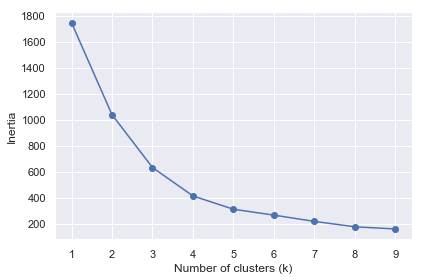

Done!


In [55]:
# Now do the KMeans clustering using different numbers of
# clusters to try and find an optimal number of clusters
# -------------------------------------------------------
# Create a range for the number of clusters we want to try
numClusters = range(1, 10)

# Create a blank list to hold the inertia values calculated for each number of clusters
inertias = []

# Loop through each of the number of clusters, generate a KMeans model,
# and get its inertia
for k in numClusters:
    # Create a KMeans model instance with k clusters and fit it to the samples
    clusterModel = KMeans(n_clusters=k)

    # Fit the current model to the scaled data
    clusterModel.fit(df_sub_scaled)
    #clusterModel.fit(df_sub)

    # Append the inertia from the current model to the list of inertias
    inertias.append(clusterModel.inertia_)

# Plot the number of clusters vs the inertia values
fig = plt.figure()
plt.plot(numClusters, inertias, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(numClusters)
fig.tight_layout()
plt.show()

print('Done!')

In [56]:
def generate_3d_plot(plot_df, plot_features, plot_labels, cluster_labels):
    """Generate a 3D scatter plot for 3 variables

    :param plot_df: The data frame that contains the data for the features to plot
    :param plot_features: A list of 3 variables/features to plot
    :param plot_labels: A list of 3 axes labels to correspond to the plotted variables
    :param cluster_labels: An ndarray that contains the labels for how to color the points
    :return: Nothing
    """
    # Plot the data for the 3 Features of the events in 3 dimensions to have a quick look
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create the scatter plot - first 3 parameters are x, y, and z values
    ax.scatter(plot_df[plot_features[0]], plot_df[plot_features[1]], plot_df[plot_features[2]],
               c=cluster_labels, marker='o', edgecolor='black')
    # Set the labels on the 3 axes
    ax.set_xlabel(plot_labels[0])
    ax.set_ylabel(plot_labels[1])
    ax.set_zlabel(plot_labels[2])
    plt.show()
    
    # open file or show dialog asking for the number of clusters/ number of end uses inside a household. Elbow method might underestimate the numbers since faucets and showers are expected to have similar flow rates but with different durations

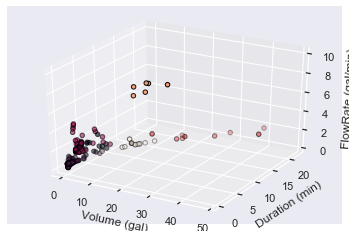

Done!


In [57]:
k = 6 
# Create a K-means model instance with k clusters and fit it to the samples
clusterModel = KMeans(n_clusters=k)
# Fit the model to the scaled data
clusterModel.fit(df_sub_scaled) 


# Use the K-means predict() function to use the model we just created to
# predict which cluster each of the events falls into. The labels object
# contains a label for for each event indicating which cluster it belongs to
labels = clusterModel.predict(df_sub_scaled)


# Create a 3-dimensional plot of the scaled event data and color each event
# based on the cluster labels - Call the function to generate the 3D plot
generate_3d_plot(Events_sub, features, featureLabels, labels)

# Add the cluster labels as a new series to the data frame of events
# that doesn't include the outlier events
Events['Cluster'] = labels

# Write the event data with cluster numbers out to a CSV file
Events.to_csv(r'/Users/nouri/Desktop/ClusterEventsData.csv', index = None, header=True)

print('Done!')